# **MGL869 - Projet personnel**

*MGL869 ETS Montreal - Production engineering*

## **Authors**
- **William PHAN**

---

## **Part 1 : Collecte des données**

In [1]:
from Jira import jira_download
from pandas import Index
from numpy import ndarray


### **1.1 - Téléchargement des données Jira**

Nous téléchargeons les données si elles ne sont pas déjà présentes dans le dossier de données.

Renvoie le dataframe des données.

Le filtre de requête peut être défini dans le fichier config.ini.

In [2]:
jira_dataframe = jira_download()

Data already downloaded
Filter = 'project=HIVE AND issuetype=Bug AND status in (Resolved, Closed) AND affectedVersion>= 2.0.0'


### **1.2 - Nettoyer les données Jira en utilisant pandas**

Auparavant, nous avons téléchargé toutes les données de Jira. Maintenant, nous allons nettoyer les données en utilisant pandas. Nous allons conserver seulement certaines colonnes et combiner certaines colonnes.

In [3]:
keep: [str] = ['Issue key', 'Status', 'Resolution', 'Created', 'Fix Versions Combined', 'Affects Versions Combined', 'Priority']

In [4]:
affects_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Affects Version/s')]
jira_dataframe['Affects Versions Combined'] = jira_dataframe[affects_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)

In [5]:
# Combine the versions into a single column
fix_version_columns: [str] = [col for col in jira_dataframe.columns if col.startswith('Fix Version/s')]

jira_dataframe['Fix Versions Combined'] = jira_dataframe[fix_version_columns].apply(
    lambda x: ', '.join(x.dropna().astype(str)), axis=1
)
jira_dataframe = jira_dataframe.loc[:, keep]
jira_dataframe

,Issue key,Status,Resolution,Created,Fix Versions Combined,Affects Versions Combined,Priority
0,HIVE-28515,Resolved,Fixed,10/Sep/24 06:55,"4.0.1, 4.1.0",4.0.0,Major
1,HIVE-28487,Resolved,Fixed,29/Aug/24 10:28,"4.0.1, 4.1.0",4.0.0,Minor
2,HIVE-28451,Resolved,Fixed,19/Aug/24 13:12,"4.0.1, 4.1.0",4.0.0,Major
3,HIVE-28439,Resolved,Fixed,07/Aug/24 13:23,"4.0.1, 4.1.0",4.0.0,Major
4,HIVE-28426,Resolved,Won't Fix,01/Aug/24 14:15,Not Applicable,4.0.0,Minor
...,...,...,...,...,...,...,...
2241,HIVE-7428,Resolved,Duplicate,16/Jul/14 17:44,,"1.2.0, 1.3.0, 2.0.0",Major
2242,HIVE-7239,Closed,Fixed,16/Jun/14 18:47,2.2.0,2.1.0,Major
2243,HIVE-4413,Resolved,Not A Problem,24/Apr/13 11:43,,"0.10.0, 0.14.0, 1.2.0, 1.2.1, 2.0.0",Major
2244,HIVE-4243,Closed,Fixed,28/Mar/13 15:02,2.0.0,"1.3.0, 2.0.0",Major


In [6]:
# Identify columns whose names contain the string 'Issue key'
issue_key_columns: Index = jira_dataframe.columns[jira_dataframe.columns.str.contains('Issue key')]
# Extract the values from these columns as a NumPy array
issue_key_values: ndarray = jira_dataframe[issue_key_columns].values
# Flatten the array to create a one-dimensional list of all 'Issue key' values
flattened_issue_keys: ndarray = issue_key_values.flatten()
# Convert the list into a set to remove duplicates
ids: set = set(flattened_issue_keys)

---


## **Part 2 : Analyse du répo git**


In [7]:
from Hive import git_download, commit_analysis, update_commit_dataframe, filter_versions_by_min
from git import Repo, Tag
from pandas import DataFrame
from configparser import ConfigParser
from re import compile
from packaging import version  

### **2.1 - Clonage du répo**

In [8]:
repo: Repo = git_download()

Output/hive_data/hiveRepo False
Pulling the repository: https://github.com/apache/hive.git


In [9]:
all_couples = commit_analysis(ids)

20524 couples found.


### **2.2 - Filtrage des données et couples**

In [10]:
commit_dataframe: DataFrame = DataFrame(all_couples, columns=["Issue key", "File", "Commit"])

In [11]:
# Languages without whitespaces
config: ConfigParser = ConfigParser()
config.read("config.ini")
languages: [str] = config["GENERAL"]["Languages"].split(",")
languages: [str] = [lang.strip() for lang in languages]
commit_dataframe: DataFrame = commit_dataframe[commit_dataframe['File'].str.endswith(tuple(languages))]

In [12]:
couples = update_commit_dataframe(commit_dataframe, jira_dataframe)
couples
# filtered_couples = couples[couples['Version Affected'].str.contains('2.3.9', na=False)]
# filtered_couples

,Issue key,File,Version Affected,Priority
0,HIVE-21614,ql/src/test/org/apache/hadoop/hive/metastore/T...,"2.3.4, 3.0.0",Major
1,HIVE-21614,standalone-metastore/metastore-server/src/main...,"2.3.4, 3.0.0",Major
2,HIVE-21614,standalone-metastore/metastore-server/src/main...,"2.3.4, 3.0.0",Major
3,HIVE-28366,iceberg/iceberg-handler/src/main/java/org/apac...,4.0.0,Major
4,HIVE-28366,iceberg/iceberg-handler/src/main/java/org/apac...,4.0.0,Major
...,...,...,...,...
10268,HIVE-17720,ql/src/java/org/apache/hadoop/hive/ql/metadata...,3.0.0,Major
10269,HIVE-17706,itests/util/src/main/java/org/apache/hadoop/hi...,3.0.0,Major
10270,HIVE-17706,itests/util/src/main/java/org/apache/hive/beel...,3.0.0,Major
10271,HIVE-17706,itests/util/src/main/java/org/apache/hive/beel...,3.0.0,Major


In [13]:
distinct_priorities = jira_dataframe['Priority'].dropna().unique()
distinct_priorities

array(['Major', 'Minor', 'Critical', 'Blocker', 'Trivial'], dtype=object)

### **2.3 - Collecte des versions filtrées**

In [14]:
releases_regex: [str] = config["GIT"]["ReleasesRegex"].split(",")
tags: Tag = repo.tags
versions: dict = {tag.name: tag.commit for tag in tags}
releases_regex: [str] = [regex.strip() for regex in releases_regex]
releases_regex = [compile(regex) for regex in releases_regex]

## **Part 3. - Métriques dynamiques**

In [15]:
from Dynamic import convert_json_to_csv, merge_static_and_dynamic_csv, build_dependencies, display_hierarchy, collect_dynamic_metrics_v2, merge
from Hive import filter_versions_by_min
from configparser import ConfigParser
import os

In [16]:
all_versions = filter_versions_by_min(versions, releases_regex,'1.0')
version_json = build_dependencies(all_versions)
#display_hierarchy(version_json)
#version_json

In [17]:
dynamic_metrics = collect_dynamic_metrics_v2(version_json)

Dynamic Metrics have already been collected. Skipping...


In [18]:
convert_json_to_csv()

Conversion of dynamic metrics to csv has already been done. Skipping...


In [19]:
merge_static_and_dynamic_csv()

Merging has already been done. Skipping...


In [20]:
config = ConfigParser()
config.read("config.ini")

base_dir = config["GENERAL"]["DataDirectory"]
source_dir = os.path.join(base_dir, config["OUTPUT"]["AllMetricsOutputDirectory"])
destination_dir = os.path.join(base_dir, config["DYNAMIC"]["AllMetricsSubDir"])
output_filename = config["DYNAMIC"]["AllMetricsFile"] 

merge(source_dir=source_dir, destination_dir=destination_dir, output_filename=output_filename)

Merging has already been done. Skipping...


## **Part 4. - Nouveau modèle et évaluation**

In [21]:
import os
from configparser import ConfigParser
from AI import plot_feature_importance_rf, plot_shap_summary,plot_shap_lr, evaluate_model, train_model, load_and_prepare_data, load_config
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [22]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

['config.ini']

### **4.1 Evaluation du nouveau modèle**

#### **4.1.1 Comparaison LR/RF en termes de performances**

In [23]:
data_directory = config["GENERAL"]["DataDirectory"]
output_dir = config["DYNAMIC"]["AllMetricsSubDir"]
file_name = config["DYNAMIC"]["AllMetricsFile"]
file_path = os.path.join(data_directory, output_dir, file_name)

In [24]:
# Retrieve configuration settings
config_section = "VERSION_ALL"
param = load_config(config_section)

model_instance_lr = LogisticRegression(max_iter=5000, class_weight='balanced')
print("Running pipeline with the model: Logistic Regression")
X_train_lr, X_test_lr, y_train_lr, y_test_lr = load_and_prepare_data(file_path,param)
trained_model_lr = train_model(model_instance_lr, X_train_lr, y_train_lr)
metrics_lr = evaluate_model(trained_model_lr, X_test_lr, y_test_lr) 

# Random Forest
model_instance_rf = RandomForestClassifier(max_depth=param['max_depth'], n_estimators=param['n_estimators'], class_weight='balanced', random_state=param['random_state'])
X_train_rf, X_test_rf, y_train_rf, y_test_rf = load_and_prepare_data(file_path,param)
print("Running pipeline with the model: Random Forest")
trained_model_rf = train_model(model_instance_rf, X_train_rf, y_train_rf)
metrics_rf = evaluate_model(trained_model_rf, X_test_rf, y_test_rf)


Running pipeline with the model: Logistic Regression
Scaler fit/transform time: 0.06 seconds
Training time: 1.41 seconds
Prediction time: 0.01 seconds
Scaler fit/transform time: 0.05 seconds
Running pipeline with the model: Random Forest
Training time: 24.05 seconds
Prediction time: 0.31 seconds


In [25]:
metrics_lr

{'AUC': np.float64(0.9357035274348062),
 'Precision': np.float64(0.9053830663340446),
 'Recall': np.float64(0.8469605803295283),
 'FPR': [0.0,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  5.64190809331716e-05,
  8.462862139975739e-05,
  8.462862139975739e-05,
  0.0001128381618663432,
  0.0001128381618663432,
  0.000141047702332929,
  0.000141047702332929,
  0.00016925724279951478,
  0.00016925724279951478,
  0.0001974667832661006,
  0.0001974667832661006,
  0.0002256763237326864,
  0.0002256763237326864,
  0.0002538858641992722,
  0.0002538858641992722,
  0.000282095404665858,
  0.000282095404665858,
  0.0003103049451324438,
  0.0003103049451324438,
  0.00033851448559902957,
  0.00033851448559902957,
  0.0003667240260656154,
  0.0003667240260656154,
  0.0003949335665322012,
  0.0003949335665322012,
  0.0004513526474

In [26]:
metrics_rf

{'AUC': np.float64(0.9830449664627778),
 'Precision': np.float64(0.9285065561673383),
 'Recall': np.float64(0.9198391722431536),
 'FPR': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0

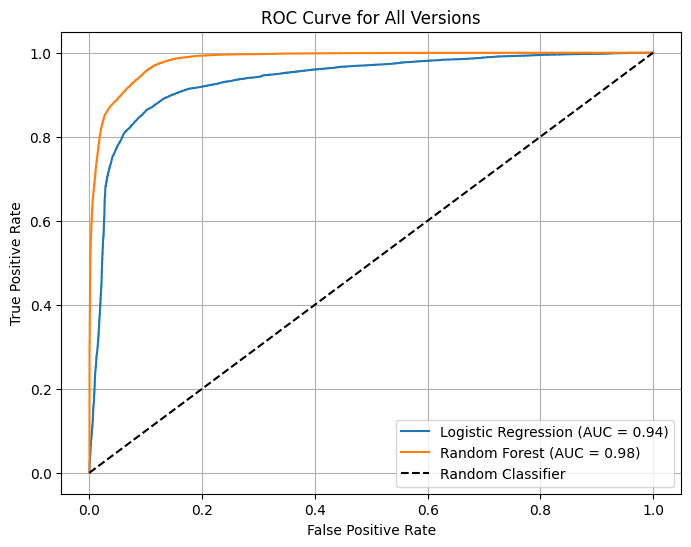

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(metrics_lr["FPR"], metrics_lr["TPR"],
         label=f"Logistic Regression (AUC = {metrics_lr['AUC']:.2f})")
plt.plot(metrics_rf["FPR"], metrics_rf["TPR"],
         label=f"Random Forest (AUC = {metrics_rf['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Versions')
plt.legend()
plt.grid()
plt.show()

#### **4.1.2 Comparaison avec le Lab en termes de performances**


##### Modèle avec uniquement les métriques statiques
- **AUC (Logistic Regression) :** 0.64
- **AUC (Random Forest) :** 0.97
- **Précision :** 96 % pour Random Forest contre 63 % pour Logistic Regression.
- **Rappel :** Random Forest atteint un rappel de 91 %, tandis que Logistic Regression est bien inférieur (46 %).

Le modèle basé uniquement sur les métriques statiques montre une forte dominance de Random Forest par rapport à Logistic Regression. Les métriques comme l'AUC, la précision et le rappel indiquent que Random Forest est capable de séparer efficacement les classes positives et négatives.

##### Modèle avec les métriques dynamiques et statiques combinées
- **AUC (Logistic Regression) :** 0.94
- **AUC (Random Forest) :** 0.98
- **Précision :** Random Forest atteint une précision encore plus élevée de 98 %, montrant une amélioration notable par rapport au modèle avec uniquement les métriques statiques.
- **Rappel :** Random Forest conserve un rappel élevé de 91 %, ce qui montre sa capacité à détecter presque tous les vrais positifs.

L'intégration des métriques dynamiques améliore les performances globales des deux algorithmes, mais Random Forest reste le modèle le plus performant.

##### Discussion

1. **Impact des métriques dynamiques :**
   Les métriques dynamiques, en complément des métriques statiques, ajoutent des informations contextuelles sur le comportement des entités observées. Cela permet d'améliorer la distinction entre les classes et d'augmenter la robustesse du modèle. Cette amélioration est particulièrement visible avec Logistic Regression, dont l'AUC passe de 0.64 à 0.94, montrant qu'il profite considérablement de ces nouvelles données.

2. **Performance relative de Random Forest :**
   Random Forest continue de surpasser Logistic Regression avec une AUC presque parfaite (0.98). L'amélioration est moins marquée pour Random Forest, car ce modèle est déjà très performant avec uniquement les métriques statiques. Cela indique que Random Forest exploite efficacement les interactions entre les métriques, qu'elles soient statiques ou dynamiques. Une attention particulière a été portée à l'algorithme RF pour éviter l'overfitting, notamment max_depth a été fixé et le poids des classes ajustés étant donné que BugStatus est souvent la classe minoritaire.

3. **Limites du modèle statique :**
   Le modèle avec uniquement les métriques statiques peut être limité dans des scénarios où les dynamiques temporelles ou les variations contextuelles jouent un rôle clé. Par exemple, des métriques comme le changement de classe ou les interactions entre entités ne sont pas capturées par les données statiques.

#### **4.1.3 Conclusion**

Le nouveau modèle, qui combine les métriques dynamiques et statiques, montre des performances globalement supérieures, notamment pour Logistic Regression. Random Forest reste le meilleur choix en termes de robustesse et de précision. L'ajout des métriques dynamiques permet de renforcer la capacité de distinction entre les classes, rendant les modèles plus adaptés à des scénarios complexes.

### **4.2 Évaluation du nouveau modèle en termes de métriques**

#### **4.2.1 Affichage des nouvelles métriques LR/RF**


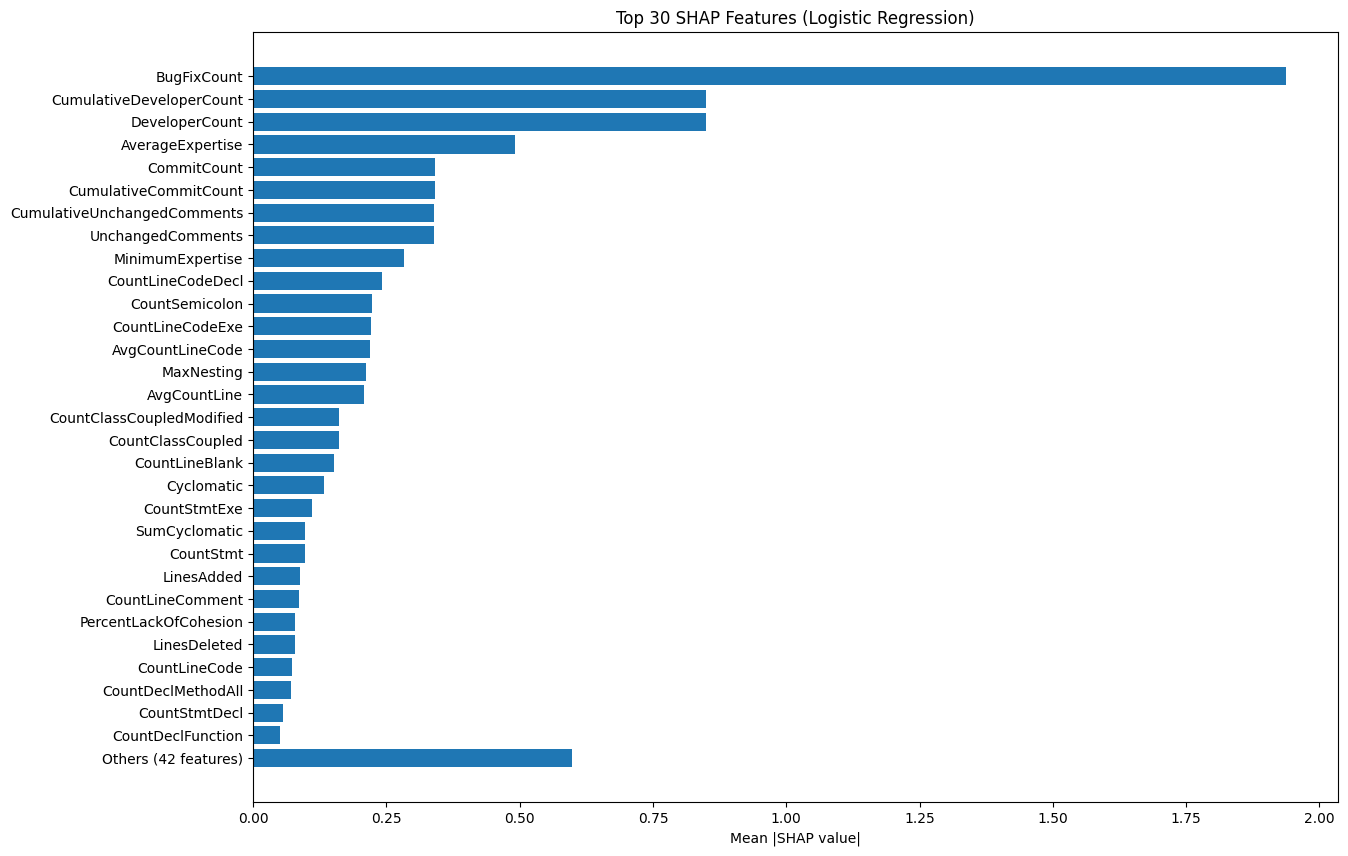

In [28]:
plot_shap_lr(trained_model=trained_model_lr, X_train=X_train_lr, X_test=X_test_lr, top_n=30)

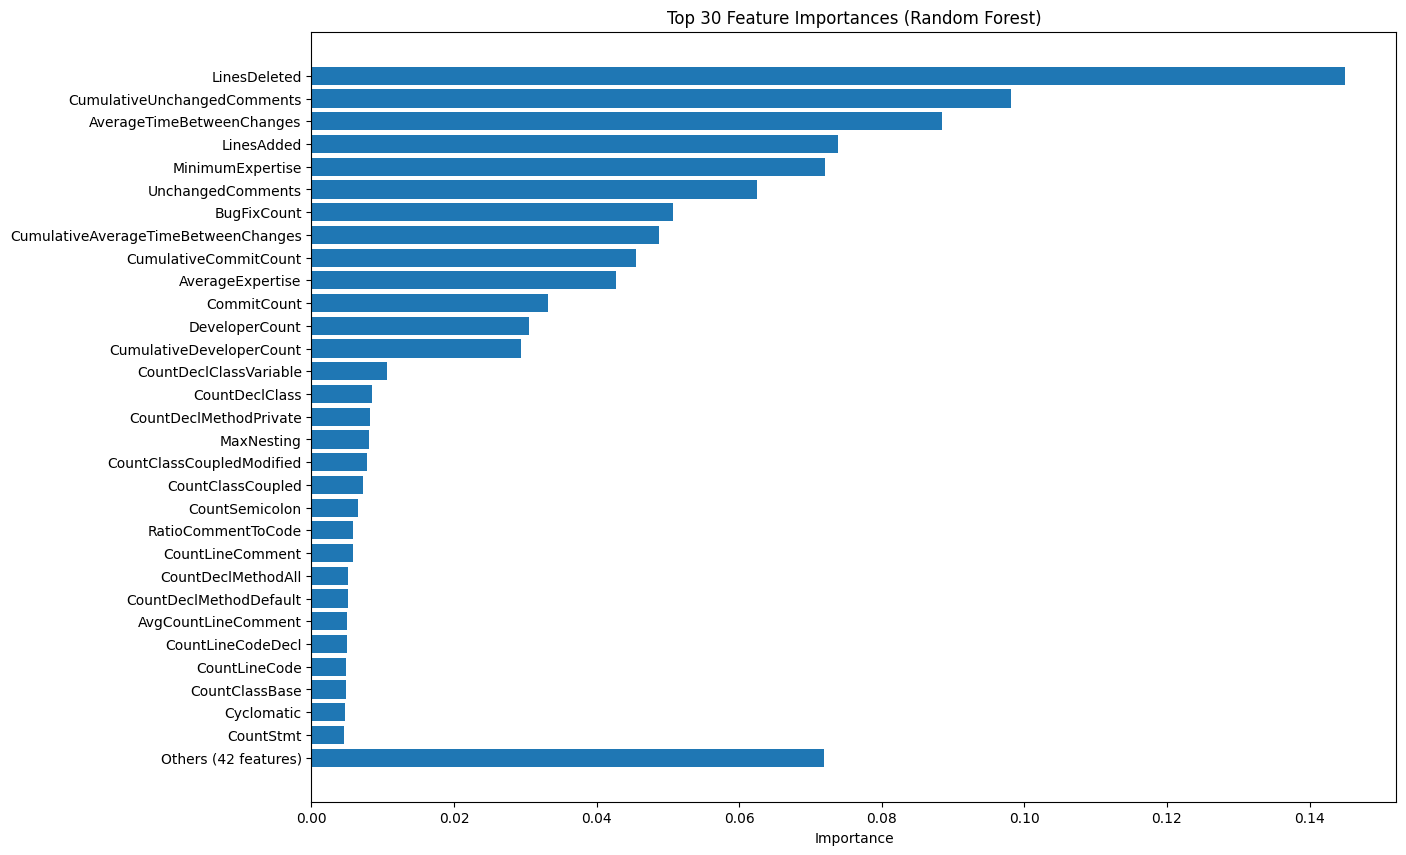

In [29]:
plot_feature_importance_rf(trained_model_rf=trained_model_rf, feature_columns=X_train_rf.columns, top_n=30)

##### Importance des métriques avant et après introduction des métriques dynamiques

Avant l'introduction des métriques dynamiques, les modèles étaient principalement influencés par des métriques statiques. Pour Random Forest, les métriques comme `CountDeclClassVariable` et `CountClassBase`, qui mesurent la complexité structurelle des classes, dominaient l'importance. Ces métriques reflètent des caractéristiques intrinsèques du code, comme le nombre de déclarations de classes ou la profondeur des hiérarchies. Dans le cas de la régression logistique, des métriques similaires, telles que `CountStmtExe` ou `CountSemicolon`, apparaissaient également comme clés. Ces résultats soulignent que, sans données dynamiques, les modèles s'appuient uniquement sur la structure statique du code pour détecter des fichiers à risque.

Après l'intégration des métriques dynamiques, un changement notable est observé dans les modèles. Pour Random Forest, les métriques comme `LinesDeleted`, `LinesAdded` et `BugFixCount` dominent désormais. Ces métriques dynamiques, liées aux activités de développement comme les commits ou les corrections de bogues, montrent une influence accrue. Elles fournissent une vue plus contextuelle et temporelle du code, permettant une meilleure prédiction des bogues. Dans le modèle de régression logistique, on remarque également que des métriques dynamiques comme `BugFixCount` et `CumulativeDeveloperCount` deviennent essentielles, marquant une évolution similaire à celle de Random Forest. Ces résultats confirment que l'inclusion de métriques dynamiques enrichit la capacité des modèles à repérer les fichiers problématiques.

##### Impact des métriques dynamiques sur les performances

Les métriques dynamiques apportent des informations contextuelles supplémentaires, en capturant des aspects critiques de l'évolution du code et des comportements des développeurs. Ces informations permettent aux modèles d'identifier avec plus de précision les fichiers à risque. Pour Random Forest, l'intégration des métriques dynamiques renforce la robustesse du modèle, en augmentant légèrement la qualité des prédictions tout en maintenant un AUC élevé de 0.98. La régression logistique, quant à elle, bénéficie fortement des métriques dynamiques avec une augmentation significative de son AUC, passant de 0.64 à 0.94, bien qu'elle reste inférieure en performance à Random Forest.

Ces résultats montrent clairement que les métriques dynamiques complètent les métriques statiques en apportant des informations sur l'évolution et l'activité du code. Leur inclusion est essentielle pour améliorer la performance globale des modèles et renforcer leur capacité à anticiper les bogues.


### **4.3 Limites au fil des versions**

In [30]:
from AI import plot_feature_importance_rf, plot_shap_summary,plot_shap_lr, evaluate_model, train_model, load_and_prepare_data, load_config, train_and_save_models, plot_metrics_evolution, filter_data_by_version, train_and_save_models_with_threads
import os, json
from configparser import ConfigParser
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [31]:
base_dir = config["GENERAL"]["DataDirectory"]
full_metrics_dir = config["OUTPUT"]["AllMetricsOutputDirectory"]
metrics_dir = os.path.join(base_dir, full_metrics_dir)
output_dir = os.path.join(base_dir, config["OUTPUT"]["AllModelsDirectory"])
file_name = config["MODEL"]["AllPerformanceMetricsFile"]
file_path = os.path.join(output_dir, file_name)
file_path

'Output/model_all_results/all_performance_metrics.json'

In [32]:
train_and_save_models_with_threads(metrics_dir, output_dir, file_name)

Model training has already been done. Skipping...


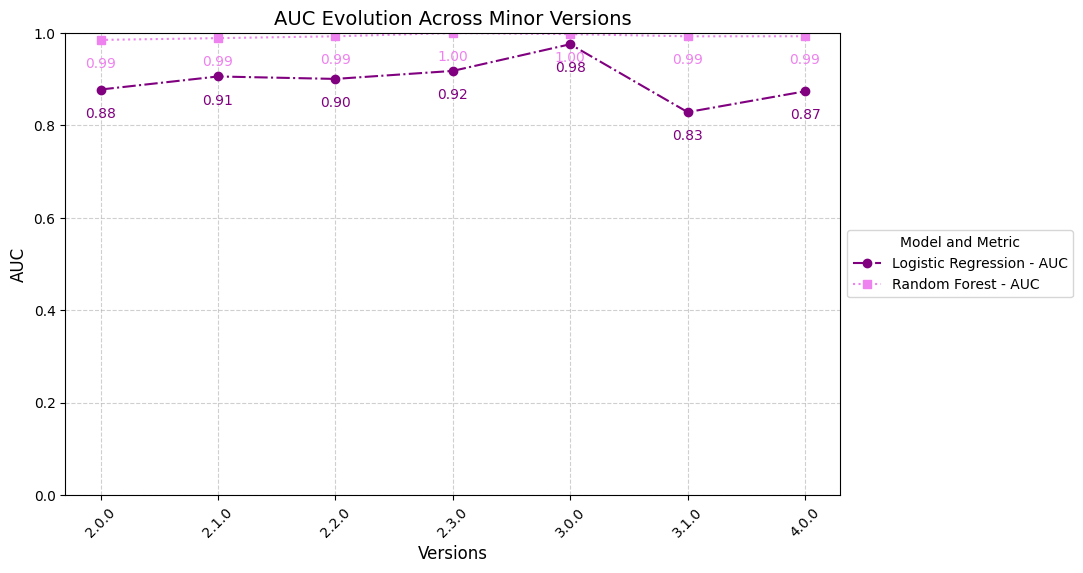

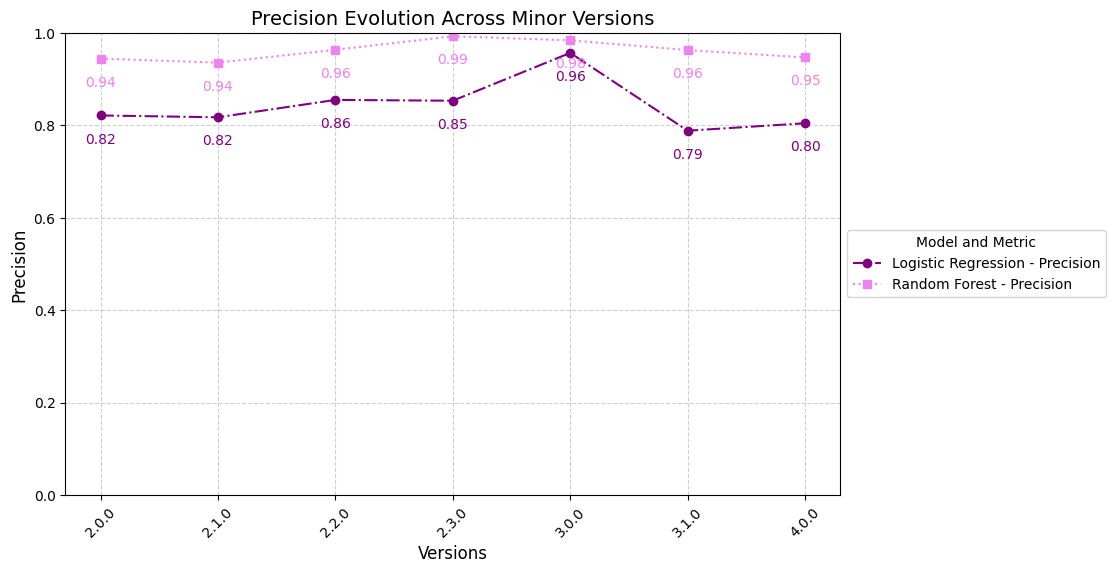

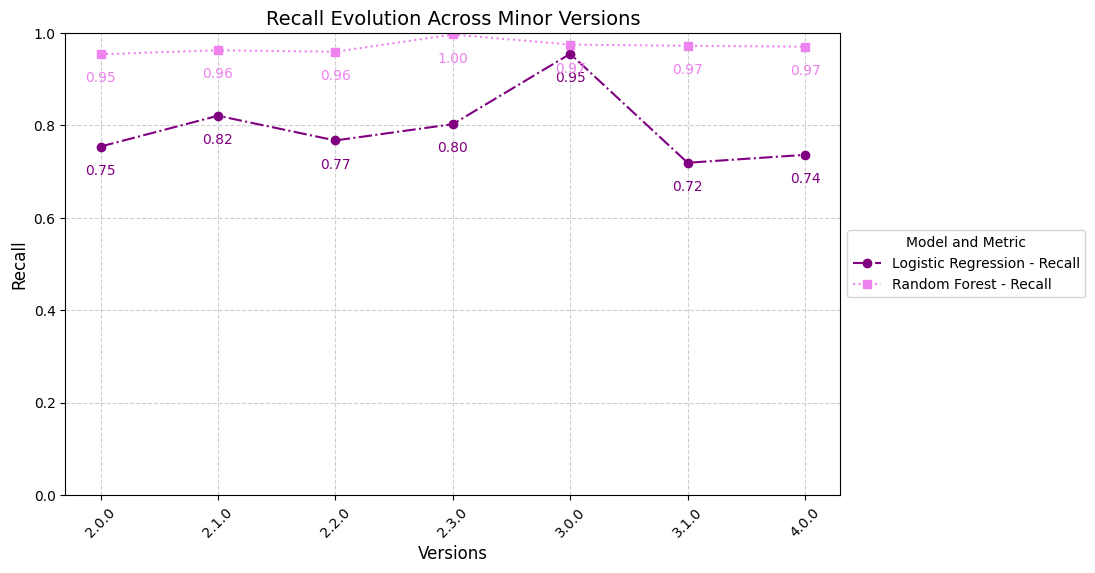

In [33]:
with open(file_path, "r") as f:
    results = json.load(f)

filtered_results = {version: metrics for version, metrics in results.items()}

plot_metrics_evolution(filtered_results)

In [34]:
data_directory = config["GENERAL"]["DataDirectory"]
output_dir = config["DYNAMIC"]["AllMetricsSubDir"]
file_name = config["DYNAMIC"]["AllMetricsFile"]
file_path = os.path.join(data_directory, output_dir, file_name)

Scaler fit/transform time: 0.00 seconds
Étude sur la version 2.0
Training time: 2.42 seconds


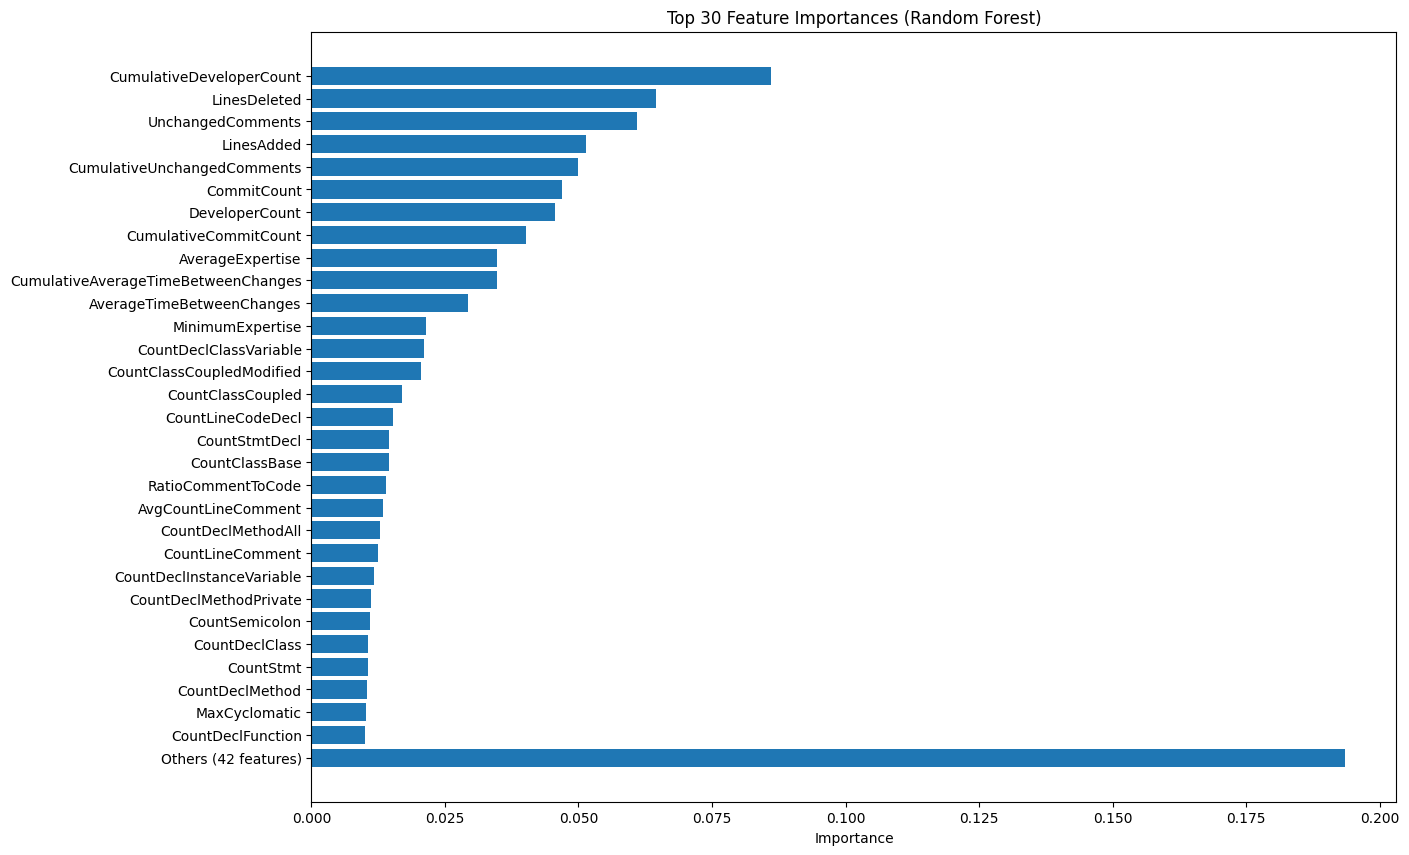

Scaler fit/transform time: 0.00 seconds
Étude sur la version 3.0
Training time: 0.68 seconds


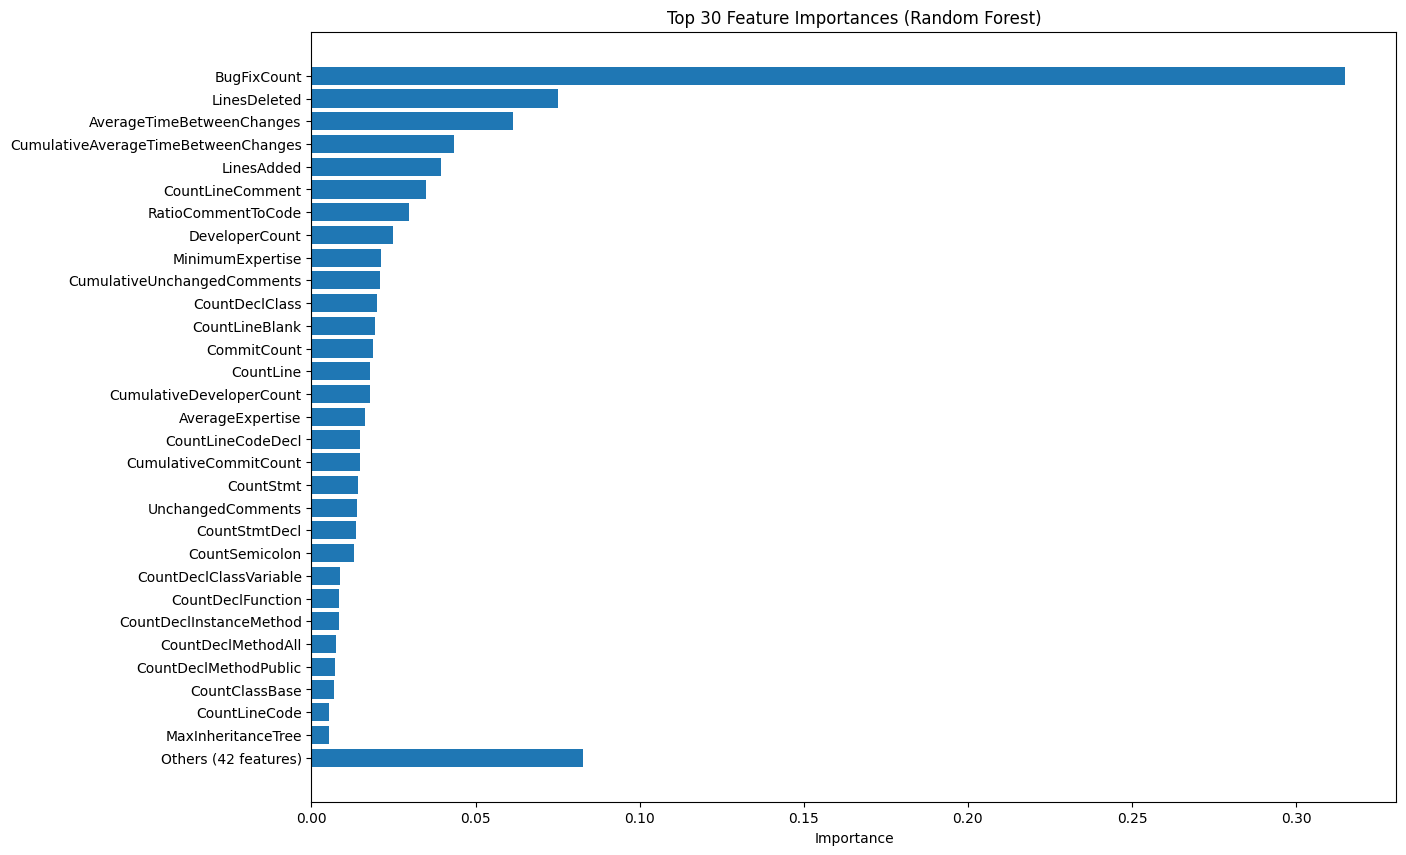

In [35]:
param = load_config("VERSION")

df = pd.read_csv(file_path, sep=",")
df['Version'] = df['Version'].astype(str)  

df_2_0 = filter_data_by_version(df, "2.0")
df_2_0 = df_2_0.drop(columns=["Version"])
X_train_2_0, X_test_2_0, y_train_2_0, y_test_2_0 = load_and_prepare_data(df_2_0, param)
print("Étude sur la version 2.0")
model_instance_rf_2_0 = RandomForestClassifier(class_weight='balanced')
trained_model_rf_2_0 = train_model(model_instance_rf_2_0, X_train_2_0, y_train_2_0)
plot_feature_importance_rf(trained_model_rf=trained_model_rf_2_0, feature_columns=X_train_2_0.columns, top_n=30)

df_3_0 = filter_data_by_version(df, "3.0")
df_3_0 = df_3_0.drop(columns=["Version"])
X_train_3_0, X_test_3_0, y_train_3_0, y_test_3_0 = load_and_prepare_data(df_3_0, param)
print("Étude sur la version 3.0")
model_instance_rf_3_0 = RandomForestClassifier(class_weight='balanced')
trained_model_rf_3_0 = train_model(model_instance_rf_3_0, X_train_3_0, y_train_3_0)
plot_feature_importance_rf(trained_model_rf=trained_model_rf_3_0, feature_columns=X_train_3_0.columns, top_n=30)

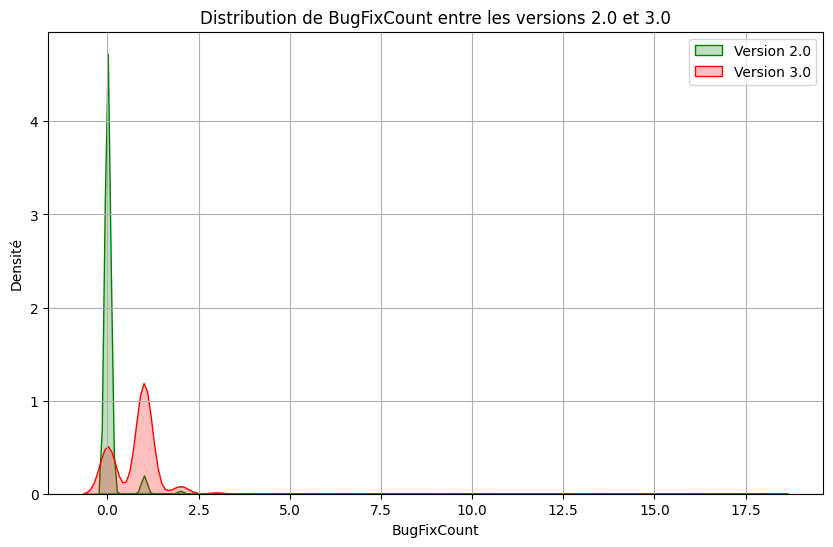

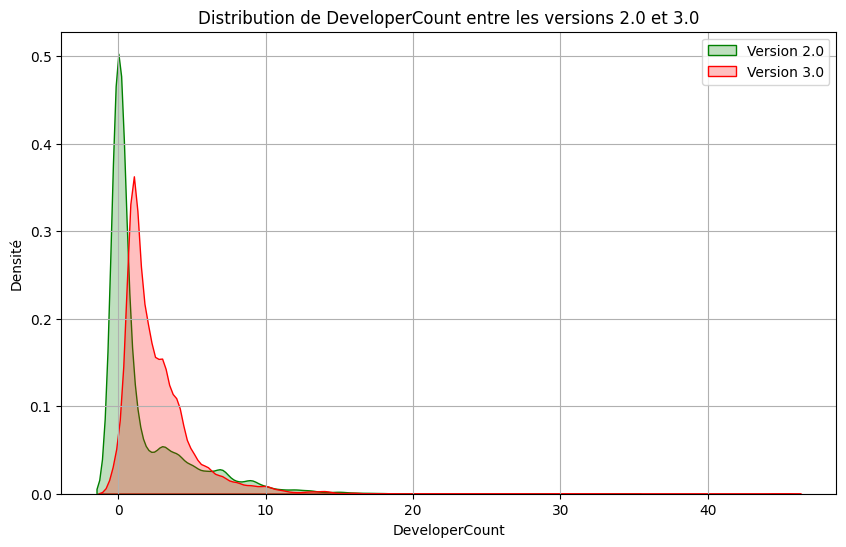

In [36]:
def plot_variable_distributions(df_2_0, df_3_0, variable):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df_2_0[variable], label="Version 2.0", color="green", fill=True)
    sns.kdeplot(df_3_0[variable], label="Version 3.0", color="red", fill=True)
    plt.title(f"Distribution de {variable} entre les versions 2.0 et 3.0")
    plt.xlabel(variable)
    plt.ylabel("Densité")
    plt.legend()
    plt.grid()
    plt.show()

# Key variables
plot_variable_distributions(df_2_0, df_3_0, "BugFixCount")
plot_variable_distributions(df_2_0, df_3_0, "DeveloperCount")

## **Part 5 - Modèle avec Classification**

In [37]:
import os
from configparser import ConfigParser
from AI import plot_feature_importance_rf, plot_shap_summary,plot_shap_lr, evaluate_model, train_model, load_and_prepare_data, load_config
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


### **5.1 - Classification pour toutes les versions**

In [38]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

['config.ini']

In [39]:
data_directory = config["GENERAL"]["DataDirectory"]
output_dir = config["DYNAMIC"]["AllMetricsSubDir"]
file_name = config["DYNAMIC"]["AllMetricsFile"]
file_path = os.path.join(data_directory, output_dir, file_name)
file_path

'Output/temp_dynamic_metrics_output/merged_all_metrics.csv'

In [ ]:
# Retrieve configuration settings
config_section = "VERSION_PROJ"
param = load_config(config_section)

# Random Forest
model_instance_rf = RandomForestClassifier(max_depth=param['max_depth'], n_estimators=param['n_estimators'], class_weight='balanced', random_state=param['random_state'])
X_train_rf, X_test_rf, y_train_rf, y_test_rf = load_and_prepare_data(file_path,param)
print("Running pipeline with the model: Random Forest")
trained_model_rf = train_model(model_instance_rf, X_train_rf, y_train_rf)
metrics_rf = evaluate_model(trained_model_rf, X_test_rf, y_test_rf)


Scaler fit/transform time: 0.05 seconds
Running pipeline with the model: Random Forest
Training time: 141.22 seconds
Prediction time: 0.74 seconds


In [41]:
metrics_rf

{'Accuracy': 0.8786445021791325,
 'F1_macro': np.float64(0.8759282332463649),
 'F1_micro': np.float64(0.8786445021791325),
 'ClassificationReport': {'None': {'precision': 0.8465169738516481,
   'recall': 0.8750742595264364,
   'f1-score': 0.8605587664573205,
   'support': 23566.0},
  'Trivial': {'precision': 0.9179652073542749,
   'recall': 0.9333556878195993,
   'f1-score': 0.9255964751849697,
   'support': 23858.0},
  'Minor': {'precision': 0.9703373316589443,
   'recall': 0.9411567054475198,
   'f1-score': 0.9555242846786918,
   'support': 23809.0},
  'Major': {'precision': 0.8187466808284652,
   'recall': 0.6514408856587509,
   'f1-score': 0.725574171686747,
   'support': 23666.0},
  'Critical': {'precision': 0.812631169840653,
   'recall': 0.8781604367912642,
   'f1-score': 0.8441259588211546,
   'support': 23810.0},
  'Blocker': {'precision': 0.8995224599138099,
   'recall': 0.9935248713550601,
   'f1-score': 0.9441897426493062,
   'support': 23320.0},
  'accuracy': 0.87864450217

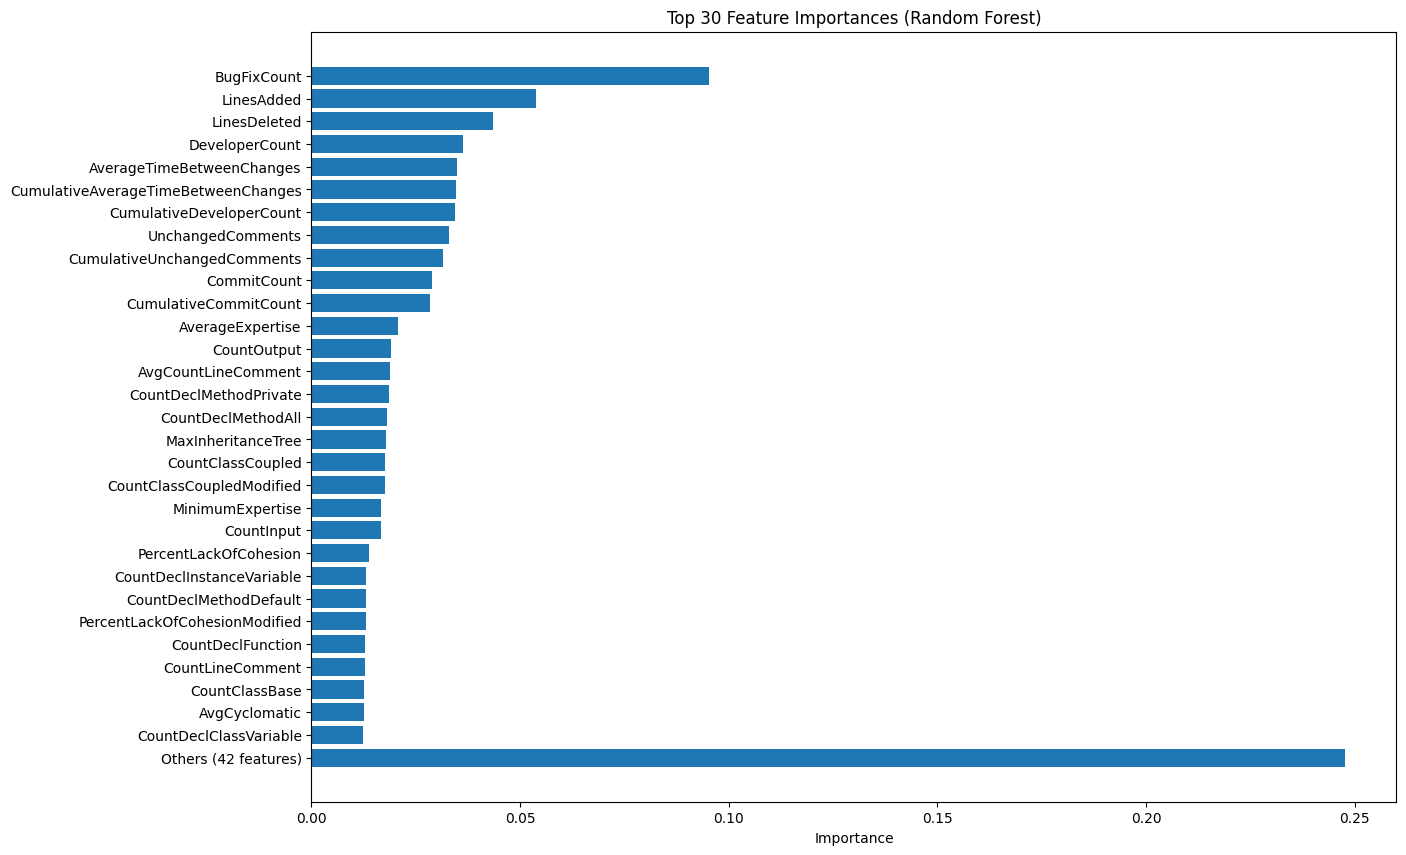

In [44]:
plot_feature_importance_rf(trained_model_rf=trained_model_rf, feature_columns=X_train_rf.columns, top_n=30)

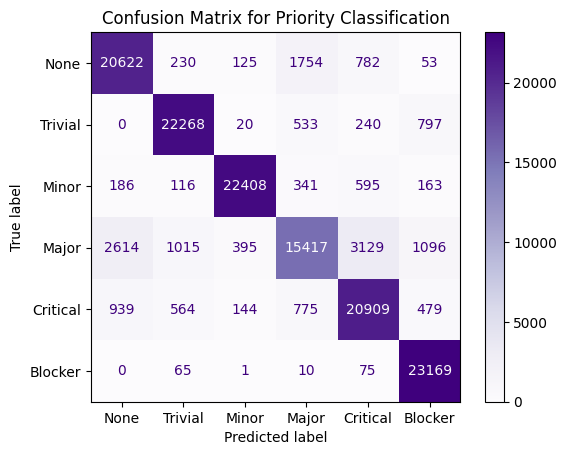

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtenir les prédictions pour le jeu de test
y_pred_rf = trained_model_rf.predict(X_test_rf)

# Générer la matrice de confusion
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Afficher la matrice de confusion avec les bonnes étiquettes
priority_labels = ["None", "Trivial", "Minor", "Major", "Critical", "Blocker"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=priority_labels)
disp.plot(cmap="Purples")
plt.title("Confusion Matrix for Priority Classification")
plt.show()


### **5.2 - Classification sur deux versions majeures**